In [1]:
import pandas as pd
import cobra
import json
import itertools
import sys

# analysis_df = pd.read_json('./Data/flanalysis_BM_SG1.json').set_index('Gene_inhibition')
# analysis_DG_df = pd.read_json('./Data/flanalysis_BM_DG1.json').set_index('Gene_inhibition')
# analysis_DG_df = pd.read_json('./Data/flanalysis_BM_DG1.json').set_index('Gene_inhibition')
# ccol_DG.json
E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")

In [184]:
SG_Biomass = pd.read_csv('./Data/BM_SG1.csv', index_col='cycle')
Biomass_df = pd.read_csv('./Data/BM_DG1.csv', index_col='cycle') 
# Biomass_df


# gr snapshot cycle
!-> generate csv for all 

In [187]:
log_step=5
def get_cycle_max_gr(desired_BM):
    max_gr = desired_BM.iloc[-1]/2
    bool_growing = ((desired_BM.iloc[-1]-desired_BM.iloc[-5])/desired_BM.iloc[-1]).apply(lambda x: x > 1e-10)
    for k, bool_grow in bool_growing.items():
        if bool_grow:
            max_gr[k] = desired_BM[k].iloc[-6]
    return max_gr
    
def find_upneighbour(df):
    max_gr = get_cycle_max_gr(df)
    position = list()
    
    def correct_cycle(cycle):
        mod = cycle%log_step
#         return cycle if mod==0 else cycle+log_step-mod # round up
        return cycle if mod==0 else cycle-mod # round down
#   
    gr_cycle = dict()
    for k, gr_value in max_gr.items():
        df_search = df.loc[:,k]
        upperneighbour_ind = df_search[df_search >= gr_value].idxmin()
#         position.append(upperneighbour_ind)
        gr_cycle[k] = correct_cycle(upperneighbour_ind)
#     cycle = [df.index[pos] for pos in position]
# #         print([df.index[pos] for pos in position])
#     cycle = [correct_cycle(cy) for cy in cycle]
    return gr_cycle

def convert_arg_to_list(arg):
    if type(arg) is not list and type(arg) is not tuple:
        arg = [arg]
    return(arg)

def get_desired_cycle(Biomass_df, regex_list=["coculture",'E0']):
    for regex in convert_arg_to_list(regex_list):
#         print(regex)
        Biomass_df = Biomass_df.filter(regex=regex) # prevent overwritten by S0, coculture
    
    desired_cycle = dict()
    
    for k,v in find_upneighbour(Biomass_df).items():
        key = k.split('_')[1]
        if desired_cycle.get(key):
            sys.exit("Halt, Gene comb keys get overwritten")
        desired_cycle[key]= v
    return desired_cycle

# filt = list(pd.Series(Biomass_df.columns).str.split('_').apply(lambda x: x[1] in cgc_list))
# desired_BM = (Biomass_df
# #               .loc[:,Biomass_df.iloc[-1]>2e-8] # filter of genes combo without growth
#               .loc[:,filt] # filter of genes combo without growth
#               .filter(regex="coculture")
#               .filter(regex='E0'))
# desired_cycle = find_upneighbour(desired_BM)

# desired_cycle = {k.split('_')[1] :v for k,v in desired_cycle.items() if 'E0' in k}
# desired_cycle

In [20]:
desired_cycle = get_desired_cycle(Biomass_df, ["coculture", 'E0'])

# Obtain pathway specific gene_combos

In [21]:
alpha_table = pd.read_csv('./Data/alpha_table.csv', index_col='Gene_inhibition')
gene_pathway_wide = pd.read_csv('./Data/gene_pathway_wide.csv', index_col='Gene_inhibition')
gene_comb_pathway_wide = pd.read_csv('./Data/gene_comb_pathway_wide.csv', index_col='Gene_inhibition')
gene_combo_pathway =  pd.read_csv('./Data/gene_combo_pathway.csv', index_col='Gene_inhibition')

In [22]:
# rework get sum row
# ! plus SG genes wilde
def remove_Zero_col(df): # extend N differ than 0 
    return(df.loc[:, (df !=0).any(axis=0)]) 

def get_sum_row(gene_comb_pathway_wide):
    XG_str = 'DG' if len(gene_comb_pathway_wide.index[0].split('.'))>1 else 'SG'
    sum_row = remove_Zero_col(
                pd.DataFrame(gene_comb_pathway_wide.sum(), columns=[f'{XG_str}_count']).T)
    pwy_ele = dict()
    df = remove_Zero_col(gene_comb_pathway_wide)
    for col in df:    
        pwy_ele[col]  = ', '.join(df.loc[df[f'{col}']==True, f'{col}'].index)
    pwy_ele_df = pd.DataFrame(pwy_ele,index=[XG_str])
    
    return pd.concat([pwy_ele_df, sum_row])

# pd.concat([gene_comb_pathway_wide, 
#            get_sum_row(gene_comb_pathway_wide)]).to_csv('./Data/gene_comb_pathway_wide_sum.csv')
get_sum_row(gene_comb_pathway_wide)

,Alternate Carbon Metabolism,Cofactor and Prosthetic Group Biosynthesis,Cell Envelope Biosynthesis,Glycine and Serine Metabolism,Arginine and Proline Metabolism,Pyruvate Metabolism,"Tyrosine, Tryptophan, and Phenylalanine Metabolism",Citric Acid Cycle,Purine and Pyrimidine Biosynthesis,Alanine and Aspartate Metabolism,Threonine and Lysine Metabolism,Pentose Phosphate Pathway,Glycolysis/Gluconeogenesis,Glutamate Metabolism,Murein Biosynthesis,Metabolite Repair
DG,"dadX.acnB, acnB.thrB, dapF.acnB, acnB.gltA, ac...","dapA.serC, serC.dapD, serC.dapB, aroA.serC, se...","dadX.rffG, murA.mrdA, murA.pyrE, rffG.pyrD, mu...","dapA.serC, serC.dapD, serC.dapB, aroA.serC, se...",aroA.argD,"acnB.ackA, acnB.purT","mrdA.aroA, dadX.aroA, aroA.serC, aroA.argD, ar...","gltA.gltD, dadX.acnB, acnB.thrB, dapF.acnB, ac...","dadX.pyrD, dadX.guaB, aroA.guaB, murA.pyrE, rf...","dadX.rffG, dadX.pyrD, dadX.guaB, dadX.acnB, da...","acnB.thrB, dapF.acnB, dapA.serC, serC.dapD, se...",tktA.gnd,"dadX.eno, dadX.gapA",gltA.gltD,"mrdA.aroA, mrdA.mrcA, mrdA.pheA, dadX.mrcA, mu...",dadX.gapA
DG_count,6,13,8,5,1,2,13,7,12,10,15,1,2,1,7,1


In [23]:
pathway_wide_summary = pd.concat([get_sum_row(gene_pathway_wide),get_sum_row(gene_comb_pathway_wide)])
# pathway_wide_summary.to_csv('./Data/pathway_wide_summary.csv')

# gene_comb in specific_pwy

In [25]:
gr_DG = pd.read_csv('./r/data fitting/standardized_gr_Div_DG_Mult_Aug31.csv', index_col='gene_inhibition')

def get_gene_combo_in_specific_pathway(desired_pathway: str):
    pwy_inhib = [k 
                 for k, pathway in gene_combo_pathway.T.items()
                 if desired_pathway in pathway[0]] # value return series] # 
    return pwy_inhib
cof_inhib = get_gene_combo_in_specific_pathway('Cofactor and Prosthetic Group Biosynthesis')
cof_DG = gr_DG.loc[cof_inhib]
# cof_DG.Predicted_additive_effect_E0_coculture-cof_DG.E0_coculture
# sum_row = get_sum_row(gene_comb_pathway_wide)

## antagonistic

In [55]:
def get_col_p_o(gr_df):
    col_p_o = gr_df.Predicted_additive_effect_E0_coculture-gr_df.E0_coculture
    col_p_o[(gr_df.Predicted_additive_effect_E0_coculture < 1.5e-8) & (gr_df.E0_coculture< 1.5e-8)] = 0
    return pd.DataFrame(col_p_o, columns=['P_O'])

def get_antagonistic_df(syn_df):
    antagonistic_list = syn_df.loc[syn_df['P_O']<0].query("P_O<-0.01").index 
    # ? func get pwy col
    potential_pwy = (gene_combo_pathway
                                      .loc[antagonistic_list,'Pathway']
                                      .str.split(' \+ ') # series string need \+
                                      .apply(lambda x: sorted(x))) 
    return pd.DataFrame(potential_pwy)
        
syn_df = get_col_p_o(gr_DG)
antagonistic_df = get_antagonistic_df(syn_df)

# p-o for specific pathway 

In [61]:
def modify_inner_dict_val(inner_dict):
#     print(type(inner_dict), type(inner_dict) is dict)
    if type(inner_dict) is dict:
        values = np.array(list(inner_dict.values()))
    else:
        single_val = inner_dict
        return single_val if single_val > 0 else 1e5+abs(single_val)         
    antagonistic_bool = values<0
    values[antagonistic_bool] = 1e5+abs(values[antagonistic_bool])
    return values
#     return [max(abs(ele) for ele in inner_dict.values())] if absolute else max(inner_dict.values()) 

In [206]:
def get_sub_dict(d: Dict, keys: List[str]):
    return {k:v for k, v in d.items() if k in convert_arg_to_list(keys)}

In [89]:
def get_inner_dict_max_val(inner_dict, absolute = True):
    return [max(abs(ele) for ele in inner_dict.values())] if absolute else max(inner_dict.values()) 

def get_sorted_dict(d, **kwargs):
    print(kwargs)
    if kwargs:
        key = kwargs  
    else:
#         key = lambda item: modify_inner_dict_val(item[1])
        key = lambda item: item[1]
    return ({k: v for k, v in sorted(d.items(), 
#                                              key=lambda item: item[1])})
                                             key, reverse=True)})
#                                              kwargs, reverse=True)})

def get_sorted_dict(d, **kwargs):
    return ({k: v for k, v in sorted(d.items(), 
#                                              key=lambda item: item[1])})
                                             reverse=True, **kwargs)})

from typing import List
def get_p_o(potential_pwy_list: List[str]):
    p_o = dict()    
    # !? sep get index -> get antagon index directly
    for desired_pathway_list in potential_pwy_list:
        # cater for pathway > 2 -> nC2 pairwise combination
        for desired_pairwise_pathway_list in itertools.combinations(desired_pathway_list,2):
            similar_gene_comb = list()

            for k, pathway in gene_combo_pathway.T.items():
                found = [pathway_n in pathway[0] for pathway_n in desired_pairwise_pathway_list]
                if all(found):
                    similar_gene_comb.append(k)

            sub_dict = dict()
            # ？ use group_by?
            for gene_comb in similar_gene_comb: 
    #             sub_dict[gene_comb] = (gr_DG.loc[gene_comb,'Predicted_additive_effect_E0_coculture'] -
    #                                     gr_DG.loc[gene_comb,'E0_coculture'])
                sub_dict[gene_comb] = syn_df.loc[gene_comb, 'P_O']
            if sub_dict != dict():
                # ordering within pathway index group
                p_o[' + '.join(desired_pairwise_pathway_list)] = get_sorted_dict(sub_dict,
                                                                    key=lambda item: modify_inner_dict_val(item[1]))
                
    p_o = get_sorted_dict(p_o, key=lambda item: max(modify_inner_dict_val(item[1]))) # ordering of pathway index
    return p_o

# antagonistic_p_o = get_p_o(potential_pwy_list)

In [ ]:
# def get_antagonistic_MI_index(antagonistic_df):
#     index = list()
#     for desired_pathway_list in antagonistic_df.Pathway:
#         for i in itertools.combinations(desired_pathway_list,2):
#             index.append(' + '.join(i))
#     return index
# get_antagonistic_MI_index(antagonistic_df)

In [66]:
def layer_dict_to_MI_df(p_o):
    new_dict = {}
    for outerKey, innerDict in p_o.items():
        for innerKey, values in innerDict.items():
            new_dict[(outerKey, innerKey)] = values

    # gr_DG.loc['dapF.acnB','Predicted_additive_effect_E0_coculture'] - gr_DG.loc['dapF.acnB','E0_coculture']
    classified_DG = pd.DataFrame(new_dict, index = ['P_O']).T
    return classified_DG

In [ ]:
# classified_DG.to_csv('./Data/compare_ant_pwy.csv')

# %store classified_DG


# gene comb pathway classification

In [95]:
def get_antagonistic_MI_index(antagonistic_df):
    index = list()
    for desired_pathway_list in antagonistic_df.Pathway:
        for i in itertools.combinations(desired_pathway_list,2):
            index.append(' + '.join(i))
    return index

antagonistic_index = get_antagonistic_MI_index(antagonistic_df)
# antagonistic_index = set([first_index for first_index, _ in MI_antagonistic.index])

In [69]:
# for pathway_pair in itertools.combinations(sorted(gene_pathway_wide.columns),2):
pathway_pair_list = list(itertools.combinations(sorted(gene_pathway_wide.columns),2))
full_p_o = get_p_o(pathway_pair_list)

In [96]:
synergistic_p_o = {pwy_comb: v for pwy_comb, v in full_p_o.items() 
                   if pwy_comb not in antagonistic_index}

antagonistic_p_o = {pwy_comb: v for pwy_comb, v in full_p_o.items() 
                   if pwy_comb in antagonistic_index}
# index_order = p_o.reset_index().groupby('level_0').max().index
MI_antagonistic = layer_dict_to_MI_df(antagonistic_p_o)
MI_synergistic = layer_dict_to_MI_df(synergistic_p_o)

In [379]:
with pd.ExcelWriter('./Data/pathway_MI_df.xlsx') as writer:  # doctest: +SKIP
    MI_antagonistic.to_excel(writer, sheet_name='Antagonistic Pathway Combination')
    MI_synergistic.to_excel(writer, sheet_name='Synergistic Pathway Combination')
# pd.read_excel('./Data/pathway_MI_df.xlsx', sheet_name='Antagonistic Pathway Combination', index_col=[0,1])


D:\anaconda3\envs\vr\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Read json

In [99]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def get_rcts_list(gcomb_list): 
    rcts_list = list()
    rcts_set = set()
    for i, gene in enumerate(gcomb_list):
        gene_rcts = [rct.id for rct in E0.genes.get_by_id(get_gene_id(E0, gene)).reactions]
        if i > 0:
            gene_rcts = list(set(gene_rcts) - rcts_set)
        rcts_list.append(gene_rcts)
        rcts_set = rcts_set | set(gene_rcts)
    return rcts_list

def adjust_flux_df(df, gene_combo: list):
    if 'Normal' not in gene_combo:
#         gene_combo_dict = get_gcomb_alpha_dict(gene_combo) 
        v1_cols = df.filter(regex='v1').columns
        orig_cols = [ele.replace("_v1", '') for ele in df.filter(regex='v1').columns]
        
        gene_combo_list = gene_combo.split('.')
        rcts_list = get_rcts_list(gene_combo_list)
        scaled_rcts = list()
        for gene, rcts in zip(gene_combo_list, rcts_list):  
            rcts = [rct for rct in rcts if rct in orig_cols]
            for orig_col in rcts:
                alpha = alpha_table.loc[f'{gene}', 'E0']   
                v1_col = orig_col + "_v1"
                df[f'{orig_col}'] = (df[f'{orig_col}'] + df[f'{v1_col}'])/alpha # only forward or backward != 0               
                df = df.drop(f'{v1_col}', axis=1) 
#     print(df.filter(regex='v1').columns)
    return df

def get_desired_BM(Biomass_df = Biomass_df, regex='Normal_coculture'):
    return Biomass_df.filter(regex=regex)

In [110]:
# compare_df = compare_df.rename_axis('Reactions').reset_index()

def get_row_grmax(desired_BM, genes='Normal'): # currently only E0
    desired_cycle = find_upneighbour(desired_BM)
    dfE = analysis_df.loc[genes, 'E0_coculture_flux']
#     dfE = remove_Zero_col(pd.read_json(dfE). # no use 
    dfE = (pd.read_json(dfE). 
           query("cycle in @desired_cycle").
           drop(['x','y','cycle'], axis=1))
    dfE.index = [genes]
    
    return dfE

def get_genes_compare(gene_list, Biomass_df, regex): # generate every gene-> subset
    desired_BM = get_desired_BM(Biomass_df, regex=regex)
    compare_list = list()
    for genes in gene_list:

        temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
        """
        If ~ == flux/ not metabo
        """    
        temp_df = adjust_flux_df(temp_df, genes)
        compare_list.append(temp_df)
        
    compare_df = (remove_Zero_col(pd.concat(compare_list)).T. # row to column
                  sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    
#     compare_df = (pd.concat([
#         get_row_grmax(desired_BM, genes=genes) for genes in gene_list]).
#                   T. # row to column
#                   sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    return compare_df
# Independent Extra sorted??? 
# order by flux ordering in Esher

# compare_df = get_genes_compare(['folA', 'folP','Normal'], Biomass_df, 'Normal_coculture')

def get_abs_df(df):
    return (pd.DataFrame({colname: abs(col) for colname, col in df.items()}).
                  rename_axis('Reactions').
                  reset_index())

# compare_abs_df = get_abs_df(compare_df)

# create base layer for Normal 
# Normal_df = compare_abs_df[['Normal', 'Reactions']]

# compare_df_long = compare_df.drop('Normal', axis=1).melt(ignore_index=False, 
#                              var_name='Genes')

# flux compare

## read SG


In [179]:
SG = retrive_specific_culture('./Data/flanalysis_BM_SG1.json', 'E0_coculture_flux')

In [199]:
{k:v for k, v in SG_dc.items() if k in convert_arg_to_list('Normal')}

{'Normal': 100}

In [201]:
culture_dict.keys()

dict_keys(['dadX.aroA', 'dadX.eno', 'dadX.pheA', 'dadX.acnB', 'aroA.dapF', 'dapF.pheA', 'dapF.acnB', 'dapA.aroA', 'dadX.gapA', 'mrdA.aroA', 'acnB.thrB', 'aroA.argD', 'aroA.dapB', 'aroA.serC', 'mrdA.pheA', 'dapF.dapD', 'serC.dapB', 'serC.dapD', 'acnB.gltA', 'dapA.dapF', 'dapA.serC', 'murA.pyrE', 'serC.dapF', 'aroA.pheA', 'thrC.thrB', 'trpA.aroA', 'dadX.mrdA', 'murA.mrcA', 'murA.mrdA', 'dadX.mrcA', 'folP.folA', 'folP.folC', 'gltA.gltD', 'mrdA.mrcA', 'folC.folA', 'acnB.purT', 'acnB.ackA', 'folA.guaB', 'murA.pyrD', 'rffG.pyrD', 'pyrE.rffG', 'folC.guaB', 'folP.guaB', 'pyrE.pyrD', 'folA.rffG', 'tktA.gnd', 'aroA.guaB', 'dadX.guaB', 'dadX.pyrD', 'dadX.rffG'])

In [207]:
SG_dc = get_desired_cycle(SG_Biomass, ['E0', 'coculture'])

Normal_dict = Normal_dict = get_sub_dict(SG_dc, 'Normal')
SG_culture_dict = retrive_specific_culture('./Data/flanalysis_BM_SG.json', 'E0_coculture_flux')
Normal_flux = retrive_specific_keys(SG_culture_dict, 'E0_coculture_flux', Normal_dict)

Zero growth:  


In [190]:
Normal_dict

100

In [112]:
def supply_line(file):
#     file = f'./Data/{file}'
    with open(file) as fh:
        for line in fh:
            yield json.loads(line) 
            
def retrive_specific_culture(file, culture_key):
#     culture_key = 'E0_coculture_flux'
    supp = supply_line(file)
    flux_dict = dict()
    for line in supp:    # culture as column <=> keys
        culture_dict = line.get(f'{culture_key}')
        if culture_dict:
            return culture_dict

culture_dict = retrive_specific_culture('./Data/ccol_DG.json', 'E0_coculture_flux')

In [202]:
culture_dict.keys()

dict_keys(['dadX.aroA', 'dadX.eno', 'dadX.pheA', 'dadX.acnB', 'aroA.dapF', 'dapF.pheA', 'dapF.acnB', 'dapA.aroA', 'dadX.gapA', 'mrdA.aroA', 'acnB.thrB', 'aroA.argD', 'aroA.dapB', 'aroA.serC', 'mrdA.pheA', 'dapF.dapD', 'serC.dapB', 'serC.dapD', 'acnB.gltA', 'dapA.dapF', 'dapA.serC', 'murA.pyrE', 'serC.dapF', 'aroA.pheA', 'thrC.thrB', 'trpA.aroA', 'dadX.mrdA', 'murA.mrcA', 'murA.mrdA', 'dadX.mrcA', 'folP.folA', 'folP.folC', 'gltA.gltD', 'mrdA.mrcA', 'folC.folA', 'acnB.purT', 'acnB.ackA', 'folA.guaB', 'murA.pyrD', 'rffG.pyrD', 'pyrE.rffG', 'folC.guaB', 'folP.guaB', 'pyrE.pyrD', 'folA.rffG', 'tktA.gnd', 'aroA.guaB', 'dadX.guaB', 'dadX.pyrD', 'dadX.rffG'])

In [182]:
from typing import Dict

In [213]:
def retrive_specific_keys(file, culture_key, genes_dict: Dict[str, int]):
    
    def get_flux_dict(culture_dict, genes_dict):
        flux_dict, no_grow= dict(), list()
        for current_gene_combo, cycle in genes_dict.items():
            if cycle < 15:
                no_grow.append(current_gene_combo)
                flux_dict[current_gene_combo] = pd.DataFrame([], index = [f'{current_gene_combo}'])
            else:
                desired_js = culture_dict.get(f'{current_gene_combo}')
                temp_df = pd.read_json(desired_js).query("cycle == @cycle")
                temp_df.index = [current_gene_combo]
    #                 return temp_df, current_gene_combo
                flux_dict[current_gene_combo] = adjust_flux_df(temp_df, current_gene_combo) # df as 
#             genes_dict = {current_gene_combo: genes_dict.get(f'{current_gene_combo}') for current_gene_combo in genes_dict}  #subset of gene
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(flux_dict.values()) # pd.read_json() culture_key -> col pd.read_json()
    
    if type(file) is dict:
        return get_flux_dict(file, genes_dict)
    else:
        culture_dict = retrive_specific_culture(file, culture_key)
        return get_flux_dict(culture_dict, genes_dict) 

In [114]:
# more than 2
def query_desired_cycle(cgc_list: list):
    return {gcomb: desired_cycle[gcomb] for gcomb in cgc_list}

def get_pwypair_gp_GRT2(p_o: dict): # index greater than 2 element
    flux_compare_combos_dict = {k:v for k,v in p_o.items() if len(v)>=2}
    return flux_compare_combos_dict

# def get_cgc_df():
# compare gene combo list
flux_compare_combos_dict = get_pwypair_gp_GRT2(antagonistic_p_o)
cgc_list = list(set(inner_key for v in flux_compare_combos_dict.values() for inner_key in v.keys()))
cgc_dict = query_desired_cycle(cgc_list) # {gcomb: desired_cycle[gcomb] for gcomb in cgc_list}

# flux_compare_df = retrive_specific_keys('./Data/ccol_DG.json', 'E0_coculture_flux', cgc_dict)# 
flux_compare_df = retrive_specific_keys(culture_dict, 'E0_coculture_flux', cgc_dict)

NameError: name 'flux_compare_combos_dict' is not defined

In [165]:

anta_l = query_desired_cycle([ele for ele in 
                           antagonistic_p_o['Alternate Carbon Metabolism + Citric Acid Cycle'].keys()])
df_CM_CAC = retrive_specific_keys(culture_dict, 'E0_coculture_flux', anta_l)

Zero growth:  acnB.ackA, acnB.purT


In [218]:
df.loc['Normal']

cycle                             100.000000
x                                   1.000000
y                                   1.000000
SHK3Dr                              0.056977
DHORTS                             -0.049454
                                     ...    
TYRL                                0.000033
THZPSN3                             0.000033
PAI2T                               0.000067
4HTHRK                              0.000000
BIOMASS_Ec_iML1515_core_75p37M      0.149500
Name: Normal, Length: 462, dtype: float64

In [225]:
remove_Normal_from_list(df.index)

[True, True, True, True, False]

In [222]:
for i, gcomb in enumerate(itertools.combinations(remove_Normal_from_list(df.index), 2)):
    print(gcomb)
#     col_name = '_'.join(gcomb)
        

TypeError: 'builtin_function_or_method' object is not iterable

In [ ]:
[ele'Normal' not in ele for ele in l]

In [233]:
df.loc['Normal'][df.loc['Normal']==0] = .001

In [234]:
df.head()

,cycle,x,y,SHK3Dr,DHORTS,OMPDC,G5SD,CS,ICDHyr,PPA,...,PIt2rpp,PAI2I,LCTStpp,FESD1s,4HTHRA,TYRL,THZPSN3,PAI2T,4HTHRK,BIOMASS_Ec_iML1515_core_75p37M
acnB.thrB,240.0,1.0,1.0,0.038585,-0.033490,0.033490,0.022380,3.487197,0.108854,0.595672,...,0.867916,0.000045,2.366817,0.000395,0.000000,0.000023,0.000023,0.000045,0.000000,0.101241
acnB.gltA,345.0,1.0,1.0,0.007441,-0.006459,0.006459,0.004316,2.071413,0.020993,7.059745,...,4.215463,0.000009,0.827500,0.000000,-0.000013,0.000004,0.000004,0.000009,0.000013,0.019525
dadX.acnB,240.0,1.0,1.0,0.020740,-0.018002,0.018002,0.012030,1.874457,0.058512,0.182178,...,0.052494,0.000024,1.066058,0.000212,0.000000,0.000012,0.000012,0.000024,0.000000,0.054420
dapF.acnB,265.0,1.0,1.0,0.019254,-0.016711,0.016711,0.011167,1.740092,0.054317,0.169119,...,0.048731,0.000023,1.070240,0.000197,0.000000,0.000011,0.000011,0.000023,0.000000,0.050519
Normal,100.0,1.0,1.0,0.056977,-0.049454,0.049454,0.033048,1.675806,1.675806,0.500473,...,0.144209,0.000067,0.579861,0.000584,0.001000,0.000033,0.000033,0.000067,0.001000,0.149500


In [ ]:
# filt pwy reaction list

In [254]:
def remove_Normal_from_list(l: list):
    return [ele for ele in l if 'Normal' not in ele]

def add_normal_flux_row(df, Normal_flux):
    return pd.concat([df, Normal_flux])

def clean_flux_df(df):
    return remove_Zero_col(df.dropna())
    
def get_standardized_plot_df(df):
    
    df.loc['Normal', df.loc['Normal']==0] = .005
#     df = df
    def standardize_row(row):
        return row/df.loc['Normal']
       
    df_list = list()
    for i, gcomb in enumerate(itertools.combinations(remove_Normal_from_list(df.index), 2)):
        col_name = '_'.join(gcomb)
        if i == 0:
            sort_col = col_name
#             ? sort_col -> 'Normal'
        df_list.append(
            pd.DataFrame(
                abs(standardize_row(df.loc[gcomb[0]]-df.loc[gcomb[1]])),
#                 abs(df.loc[gcomb[0]]-df.loc[gcomb[1]]),
                columns=[f'{col_name}']))

    plot_df = (pd.concat(df_list, axis=1)
          .drop(['x','y','cycle'])
          .sort_values(f'{sort_col}', ascending=True)
          .reset_index().rename(columns={'index':'Reaction'}))
    return plot_df.loc[:,['Normal' not in ele for ele in plot_df.columns]]
    

df = clean_flux_df(add_normal_flux_row(df_CM_CAC, Normal_flux))
# plot_df_raw = get_standardized_plot_df(df)
plot_df = get_standardized_plot_df(df)

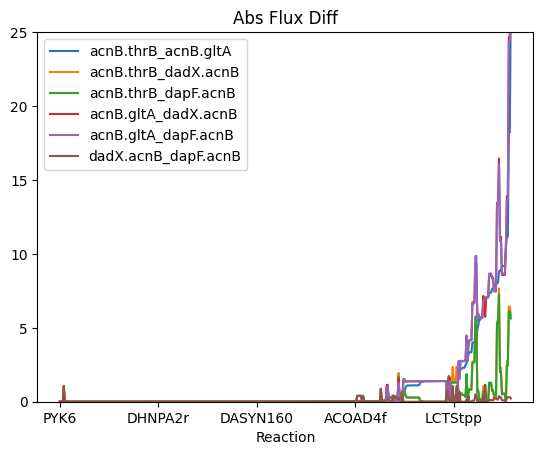

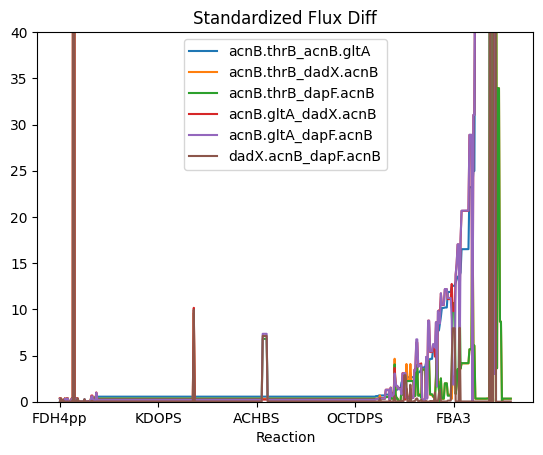

In [256]:
p_raw = plot_df_raw.plot(x='Reaction', ylim=(0,25), title='Abs Flux Diff')
p_stand = plot_df.plot(x='Reaction', ylim=(0,40), title='Standardized Flux Diff')

In [172]:
df = remove_Zero_col(df_CM_CAC.dropna())

df_list = list()
for i, gcomb in enumerate(itertools.combinations(remove_Normal_from_list(df.index), 2)):
    col_name = '_'.join(gcomb)
    if i == 0:
        sort_col = col_name
    df_list.append(pd.DataFrame(abs(df.loc[gcomb[0]]-df.loc[gcomb[1]]), columns=[f'{col_name}']))

plot_df = (pd.concat(df_list, axis=1)
      .drop(['x','y','cycle'])
      .sort_values(f'{sort_col}', ascending=True)
      .reset_index().rename(columns={'index':'Reaction'}))

plot_df = plot_df.loc[:,['Normal' not in ele for ele in plot_df.columns]]

# flux abs diff -suggested

In [537]:
cgc_list2 = antagonistic_p_o['Alternate Carbon Metabolism + Threonine and Lysine Metabolism'].keys()
cgc_dict2 = {gcomb: desired_cycle[gcomb] for gcomb in cgc_list2}
flux_compare_df = retrive_specific_keys('./Data/ccol_DG.json', 'E0_coculture_flux', cgc_dict2)

In [447]:
remove_Zero_col(flux_compare_df)

,cycle,x,y,SHK3Dr,DHORTS,OMPDC,G5SD,CS,ICDHyr,PPA,...,PYK3,PYK6,PIt2rpp,PAI2I,LCTStpp,FESD1s,TYRL,THZPSN3,PAI2T,BIOMASS_Ec_iML1515_core_75p37M
acnB.thrB,240,1,1,0.038585,-0.033490,0.033490,0.022380,3.487197,0.108854,0.595672,...,0.000000,0.000000,0.867916,0.000045,2.366817,0.000395,0.000023,0.000023,0.000045,0.101241
dapF.acnB,265,1,1,0.019254,-0.016711,0.016711,0.011167,1.740092,0.054317,0.169119,...,0.032135,0.001322,0.048731,0.000023,1.070240,0.000197,0.000011,0.000011,0.000023,0.050519


In [484]:
# df = remove_Zero_col(flux_compare_df.drop(['x','y','cycle'], axis=1))
diff = (pd.DataFrame(abs(df.iloc[0]-df.iloc[1]), columns=['value']).
reset_index().rename(columns={'index':'Reaction'}))

In [470]:
from statistics import median
m = median(diff.sort_values())
diff[diff<m]

APRAUR     0.000023
TRPAS2     0.002883
DB4PS      0.000045
ALAR       0.002114
RBFK       0.000011
             ...   
PAI2I      0.000023
FESD1s     0.000198
TYRL       0.000011
THZPSN3    0.000011
PAI2T      0.000023
Length: 219, dtype: float64

<AxesSubplot:xlabel='Reaction'>

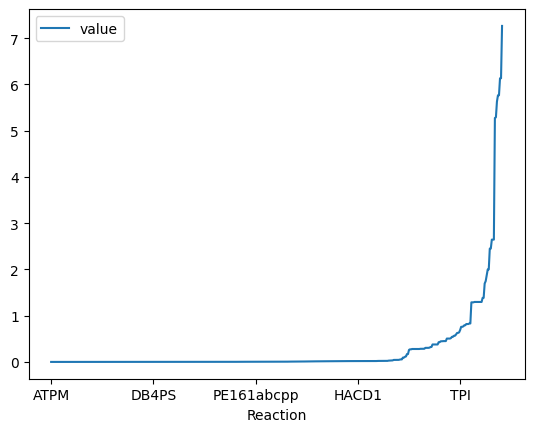

In [486]:
diff.sort_values('value').plot(x='Reaction')

# Old gr for specific genecomb

In [ ]:

def get_row_grmax(desired_BM, genes='Normal'): # currently only E0
    desired_cycle = find_upneighbour(desired_BM)
    dfE = analysis_df.loc[genes, 'E0_coculture_flux']
#     dfE = remove_Zero_col(pd.read_json(dfE). # no use 
    dfE = (pd.read_json(dfE). 
           query("cycle in @desired_cycle").
           drop(['x','y','cycle'], axis=1))
    dfE.index = [genes]
    
    return dfE

def get_genes_compare(gene_list, Biomass_df, regex): # generate every gene-> subset
    desired_BM = get_desired_BM(Biomass_df, regex=regex)
    compare_list = list()
    for genes in gene_list:

        temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
        """
        If ~ == flux/ not metabo
        """    
        temp_df = adjust_flux_df(temp_df, genes)
        compare_list.append(temp_df)
        
    compare_df = (remove_Zero_col(pd.concat(compare_list)).T. # row to column
                  sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    
#     compare_df = (pd.concat([
#         get_row_grmax(desired_BM, genes=genes) for genes in gene_list]).
#                   T. # row to column
#                   sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    return compare_df
# Independent Extra sorted??? 
# order by flux ordering in Esher

# compare_df = get_genes_compare(['folA', 'folP','Normal'], Biomass_df, 'Normal_coculture')

In [ ]:
# # create base layer for Normal 
# Normal_df = compare_abs_df[['Normal', 'Reactions']]

# compare_df_long = compare_df.drop('Normal', axis=1).melt(ignore_index=False, 
#                              var_name='Genes')

# compare df

In [ ]:

# compare_df = get_genes_compare(['folA', 'folP','Normal'], Biomass_df, 'Normal_coculture')

def get_abs_df(df):
    return (pd.DataFrame({colname: abs(col) for colname, col in df.items()}).
                  rename_axis('Reactions').
                  reset_index())

# compare_abs_df = get_abs_df(compare_df)

# create base layer for Normal 
# Normal_df = compare_abs_df[['Normal', 'Reactions']]

# compare_df_long = compare_df.drop('Normal', axis=1).melt(ignore_index=False, 
#                              var_name='Genes')

# plot flux dist

In [ ]:
from plotnine import ggplot, geom_area, aes
# base = ggplot(df.iloc[:30,], aes(x='Reactions', y='Normal',group=1))+geom_area(fill = 'grey',alpha=0.5)
base = ggplot(normal_df1.iloc[:30,], aes(x='Reactions', y='Normal',group=1))+geom_area(fill = 'grey',alpha=0.5)


In [ ]:
from plotnine.ggplot import *
from plotnine import (
    ggplot,
    aes,
    geom_col,
    geom_text,
    position_dodge,
    lims,
    theme,
    element_text,
    element_blank,
    element_rect,
    element_line,
)

In [ ]:
# p = (ggplot(genes_df, aes(x='Reactions', y='Genes',group=1))+
#      geom_area()+
#      facet_wrap('Genes'))

In [ ]:
import plotnine.options as plopt
plopt.figure_size = (16,20)


In [ ]:
(base+
     geom_area(mapping=aes(x='Reactions', y='value',group=1), data=genes_df1,
               fill='red', alpha = 0.3, show_legend= True)+
     facet_wrap('Genes')+
     theme(axis_text_x=element_text(angle=90)
))

In [ ]:
(ggplot(genes_df1, aes(x='Reactions', y='value',group=1))+
     geom_area(fill='red')+
     facet_wrap('Genes')+
     theme(axis_text_x=element_text(angle=60)))

In [ ]:
(base+ geom_area(aes(x='Reactions', y='folA'), fill='red') + 
    theme(axis_text_x=element_text(angle=60)))　
 

In [ ]:
from plotnine import *

In [ ]:

compare_df_long = compare_df_long.rename_axis('Reactions').reset_index()


In [ ]:
# compare_df_long = compare_df_long.rename_axis('Reactions').reset_index()
compare_df_long.value = compare_df_long.value.abs()

In [ ]:
compare_df_long.columns

In [ ]:
import seaborn as sns
g = sns.FacetGrid(compare_df_long, col='Genes')
g.map(sns.lineplot,'Reactions', 'value')

In [ ]:
Normal_df = compare_abs_df[['Normal']]

Normal_df = Normal_df.rename_axis('Reactions').reset_index()

In [ ]:
from plotnine import *
ggplot(survs_df, aes(x='weight', y='hindfoot_length')) + geom_point()



In [ ]:
# n=50
compare_df_long = compare_df.melt(ignore_index=False, var_name='Genes')
compare_df_long = compare_df_long.rename_axis('Flux').reset_index()
compare_df_long.value = compare_df_long.value.abs()

In [ ]:
so.Plot(compare_df_long, 'Flux', 'value', color = 'Genes').add(so.Area(alpha=.5))


In [ ]:
import seaborn.objects as so
so.Plot(compare_df_long, 'Flux', 'value', color = 'Genes').add(so.Area(alpha=.5))


In [ ]:
Normal_df

In [ ]:
so.Plot(Normal_df, 'Reactions', 'Normal').add(so.Area(alpha=.5))


In [ ]:
compare_abs_df

In [ ]:
plt.fill_between(compare_abs_df.Reactions, compare_abs_df.Normal)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot lines
ax.plot(time, income, color="green")
ax.plot(time, expenses, color="red")

# Fill area when income > expenses with green
ax.fill_between(
    time, income, expenses, where=(income > expenses), 
    interpolate=True, color="green", alpha=0.25, 
    label="Positive"
)

# Fill area when income <= expenses with red
ax.fill_between(
    time, income, expenses, where=(income <= expenses), 
    interpolate=True, color="red", alpha=0.25,
    label="Negative")

In [ ]:
import matplotlib.pyplot as plt
plt.fill_between(compare_abs_df.Reactions, compare_abs_df.folA)

In [ ]:
geom_area(aes(x='Reactions', y='Normal'))

In [ ]:
compare_abs_df['Normal'].plot()

In [ ]:
compare_abs_df = (pd.DataFrame({colname: abs(col) for colname, col in compare_df.items()}).
                  rename_axis('Reactions').
                  reset_index())

In [ ]:
ggplot(Normal_df, aes(x='Reactions', y='Normal',group=1))+geom_path()

In [ ]:
ggplot(compare_abs_df, aes(x='Reactions', y='Normal',group=1))+geom_line()

In [ ]:
# get_row_grmax(desired_BM, genes=genes)
desired_BM = get_desired_BM(Biomass_df, regex=regex)

temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
df = temp_df
if genes != 'Normal':
    v1_cols = df.filter(regex='v1').columns
    for gene in convert_arg_to_list(genes):
        rcts = list()
        for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
            rcts.append(rct.id)

        for v1_col in (set(v1_cols) & set(rcts)): # associated with gene/ find from gene
            original_col = v1_col.replace("_v1", '')
            df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
            df.drop(f'{v1_col}', axis=1)
            v1_cols.drop(f'{v1_col}')

In [ ]:
if genes != 'Normal':
    v1_cols = df.filter(regex='v1').columns
    for gene in convert_arg_to_list(genes):
        rcts = list()
        for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
            rcts.append(rct.id)

        for v1_col in (set(v1_cols) and set(rcts)): # associated with gene/ find from gene
            original_col = v1_col.replace("_v1", '')
            df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
            df.drop(f'{v1_col}', axis=1)
            v1_cols.drop(f'{v1_col}')

In [ ]:
from matplotlib import cm
compare_df

In [ ]:
from joypy import joyplot
joyplot(compare_df, by = 'Genes', column = 'value', color = 'Orange', fade = True)

In [ ]:
compare_df

In [ ]:
%load_ext rpy2.ipython

%R

In [ ]:
dfE

In [ ]:
!pip install yapf

In [ ]:
# desired_cycle = find_upneighbour(desired_BM)
# dfE = remove_Zero_col(pd.read_json(dfE).
#                       query("cycle in @desired_cycle").
#                       drop(['x','y','cycle'], axis=1))

In [ ]:
ggplot

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_col,
    geom_text,
    position_dodge,
    lims,
    theme,
    element_text,
    element_blank,
    element_rect,
    element_line,
)


(ggplot(df, aes(x='variable', y='value', fill='category'))
 + geom_col()
)




In [ ]:
dfE.index = ['Normal']
a = dfE.T.sort_values(by='b', key=abs)

a.iloc[:,:10].hist()

In [ ]:
# -> merge df
sorted_flux = dfE.to_dict('records')
a

In [ ]:
dict(sorted(a.items(), key=lambda item: item[1]))

In [ ]:
import cobra
S0 = cobra.io.read_sbml_model("./models/STM_v1_0_S0.xml")


In [ ]:
S0.reactions.BIOMASS_Ec_iAF1260_core_59p81M

In [ ]:
df.BIOMASS_Ec_iML1515_core_75p37M.plot()

In [ ]:
dfS = remove_Zero_col(pd.read_json(
    N2.loc['Normal', 'S0_ac_coculture_flux']))
dfS

In [ ]:
print(dfS.columns[dfS.columns.filter(reg)])

In [ ]:
dfS.filter(regex='B').columns

In [ ]:
E_f = dfE.BIOMASS_Ec_iML1515_core_75p37M
S_f = dfS.BIOMASS_iRR1083_metals

In [ ]:
dfS = N2.loc['Normal', 'S0_ac_coculture_flux']


In [ ]:
# growth phase is when 2 start growing

In [ ]:
pd.concat([E_f, S_f], axis=1).plot()